<center>
    <b>
        <font size="+3">
            Food Pairing and Data Science
        </font>
    </b>
    <br>
    <br>
    Vincent Choo
</center>

# Introduction

[Food pairing](https://en.wikipedia.org/wiki/Foodpairing) is a principle for deciding which foods, when eaten together, are better flavor-wise. [One study, published in *Nature*](https://www.nature.com/articles/srep00196), found that Western cooking, for example, prefers to pair foods when they share many flavors, as opposed to Eastern cooking, which tends to pair foods when they contrast flavor-wise. When combined with knowledge of what foods are central to each culture, it then becomes possible to derive insights what gives each cuisine its style.

Hypothetically, a [fusion restuarant](https://en.wikipedia.org/wiki/Fusion_cuisine) might choose to cook in a distinctly Eastern style (contrasting flavors) using mostly Western ingredients. It might even be possible to generate new cuisine styles that are designed to be as different as possible from existing styles. However, before any of that happens, we'll need data on food, and lots of it.

# Overview

First, we'll need a database of flavor compounds in each kind of food ingredient. Several databases concerning food exist, such as [FoodDB](http://foodb.ca/), [FlavorNet](http://www.flavornet.org/), and [FlavorDB](https://www.ncbi.nlm.nih.gov/pubmed/29059383), but not all associate foods with the compounds they contain. The one at FlavorDB does, so we can scrape our data from the FlavorDB [website](https://cosylab.iiitd.edu.in/flavordb/).

Once we have the data, we'll need it in a form that we can easily manipulate. [``Pandas DataFrames``](https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.DataFrame.html) are a good choice - they're effectively small databases that we can access and manipulate with the power of Python's other libraries, and without the need for a SQL-like syntax.

Then, we'll be able to run all sorts of nice data visualizations and analysis methods on our ``DataFrames``.

# Acquiring Data

First things first - how do we go about scraping the data from FlavorDB?

The general steps to data scraping are:
1. **Download** the JSON files which describe the chemical makeup of the food.
    - Find the URLs which have the JSON files.
    - Iterate over the URLs that have these JSON files, and download the data in them.
2. **Process** the JSON data by converting it into a Pandas ``Dataframe``.
3. **Clean** the ``DataFrame``.

## Steps 1-2: JSON Files

A quick inspection of the FlavorDB website reveals that all of the JSON files we want are at https://cosylab.iiitd.edu.in/flavordb/entities_json?id=x, where ``x`` is an integer. Then it's a cinch to write a few functions which go to those addresses and converts those JSON files into dictionaries. 

In [39]:
# import the relevant Python packages
import urllib.request
import json

import time

import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt

In [2]:
# JSON files are at addresses of this form
def flavordb_entity_url(x):
    return "https://cosylab.iiitd.edu.in/flavordb/entities_json?id="+str(x)


# translates the JSON file at the specified web address into a dictionary
def get_flavordb_entity(x):
    # source: https://stackoverflow.com/questions/12965203/how-to-get-json-from-webpage-into-python-script
    with urllib.request.urlopen(flavordb_entity_url(x)) as url:
        return json.loads(url.read().decode())
    return None

Those dictionaries contain a lot of unnecessary information, which is why we need to specify what fields we want (and, for ease of use, what we want to rename them to).

In [3]:
# the names of the "columns" in the raw JSON objects
def flavordb_entity_cols():
    return [
        'entity_id', 'entity_alias_readable', 'entity_alias_synonyms',
        'natural_source_name', 'category_readable', 'molecules'
    ]


# what we want to rename the JSON object "columns" to
def flavordb_df_cols():
    return [
        'entity id', 'alias', 'synonyms',
        'scientific name', 'category', 'molecules'
    ]


# "subcolumns" in the "molecules" column that we are interested in
def molecules_df_cols():
    return ['pubchem id', 'common name', 'flavor profile']    

## Steps 3-4: Downloading & Cleaning

We still haven't actually wrote anything that executes - just a bunch of definitions. Right now, we need to define a bunch of stuff as setup. Then, when we download the JSON data later, we can immediately pipeline it through processing and cleaning.

The end goal is to have the data in a consistent, easy to access format. That means that I want two databases, one associating foods with food compounds, and another associating food compounds with flavors. The database columns should have the following types:
* 'entity id' and 'pubchem id' to be type ``int``
* 'alias', 'scientific name', 'category', and 'common name' to be type ``str``
* 'synonyms' and 'flavor profile' should be type ``set(str)``
* 'molecules' should be a ``set(int)``

When these columns are initially downloaded, some of them, such as 'scientific name', have mixed types - they have both strings and some other value (in this case, ``NaN``). Fortunately, not too many columns have mixed types. In particular, (if you do some preliminary work and examine the JSON files,) the columns 'entity id', 'pubchem id', and 'common name' don't require type checking, so we don't have to process those at all.

The other small thing that do here is call ``str.lower()`` on all of the strings, just so it's easier to type and it can match other recipes more easily.

In [4]:
def clean_flavordb_dataframes(flavor_df, molecules_df):
    """
    Helps ensure consistent intra-column typing and converts all strings to lowercase.
    """
    strtype = type('')
    settype = type(set())
    
    # ensuring that these columns have type str
    for k in ['alias', 'scientific name', 'category']:
        flavor_df[k] = [
            elem.lower() if isinstance(elem, strtype) else ''
            for elem in flavor_df[k]
        ]
    
    # ensuring that these columns are always a set of str
    flavor_df['synonyms'] = [
        elem if isinstance(elem, settype) else (
            set(elem.lower().split(', ') if isinstance(elem, strtype) else [''])
        )
        for elem in flavor_df['synonyms']
    ]
    
    molecules_df['flavor profile'] = [
        set([x.lower() for x in elem])
        for elem in molecules_df['flavor profile']
    ]
    
    return [
        flavor_df.groupby('entity id').first().reset_index(),
        molecules_df.groupby('pubchem id').first().reset_index()
    ]

This is where most of the work is done. ``get_flavordb_dataframes()`` is the code that ties together all three steps of data scraping: **downloading**, **processing**, and **cleaning**. It even handles errors, for when a JSON page is missing.

In [5]:
# generate dataframes from some of the JSON objects
def get_flavordb_dataframes(start, end):
    """
    Download JSON data, converts it to DataFrames, and cleans them.
    
    Returns DataFrames for both foods and molecules, as well as missing JSON entries.
    """
    # make intermediate values to make dataframes from
    flavordb_data = []
    molecules_dict = {}
    missing = [] # numbers of the missing JSON files during iteration
    
    flavordb_cols = flavordb_entity_cols()
    
    for i in range(start, end):
        # we use a try-except here because some of the JSON pages are missing
        try:
            # 1: Find the JSON file. Gets the ith food entity, as a JSON dict
            fdbe = get_flavordb_entity(i + 1)

            # get only the relevant fields (columns) of the dict
            flavordb_series = [fdbe[k] for k in flavordb_cols[:-1]]
            flavordb_series.append( # convert the field to a set
                set([m['pubchem_id'] for m in fdbe['molecules']])
            )
            flavordb_data.append(flavordb_series)

            # update the molecules dataframe with the data in 'molecules' field
            for m in fdbe['molecules']:
                if m['pubchem_id'] not in molecules_dict:
                    molecules_dict[m['pubchem_id']] = [
                        m['common_name'],
                        set(m['flavor_profile'].split('@'))
                    ]
        except urllib.error.HTTPError as e:
            if e.code == 404: # if the JSON file is missing
                missing.append(i)
            else:
                raise RuntimeError(
                    'Error while fetching JSON object from ' + flavordb_entity_url(x)
                ) from e
            
    # generate the dataframes
    flavordb_df = pd.DataFrame(
        flavordb_data,
        columns=flavordb_df_cols()
    )
    molecules_df = pd.DataFrame(
        [
            [k, v[0], v[1]]
             for k, v in molecules_dict.items()
        ],
        columns=molecules_df_cols()
    )
    
    # clean up the dataframe columns
    flavordb_df, molecules_df = clean_flavordb_dataframes(flavordb_df, molecules_df)
    
    return [flavordb_df, molecules_df, missing]

It takes a long time to download all of these JSON files. If the code somehow crashes, we'll lose all of our download progress in a few short seconds. Therefore, it's a good idea to save the download progress.

In [6]:
# updates & saves the download progress of your dataframes
def update_flavordb_dataframes(df0, df1, ranges):
    """
    Adds more data to the specified DataFrames, and saves them as CSV files.
    
    If successful, returns the specified DataFrames, now updated, and any missing JSON files.
    """
    df0_old = df0
    df1_old = df1
    missing_old = []

    # time how long it took to download the files
    start = time.time()
    
    # for each range in ranges, save your progress.
    # don't continue with the program unless everything succeeds!
    try:
        for a, b in ranges:
            df0_new, df1_new, missing_new = get_flavordb_dataframes(a, b)
            
            df0_old = df0_old.append(df0_new, ignore_index=True)
            df1_old = df1_old.append(df1_new, ignore_index=True)
            missing_old.extend(missing_new)
        
        return df0_old, df1_old, missing_old
    except:
        raise # always throw the error so you know what happened
    finally:
        # even if you throw an error, you'll have saved them as csv files
        df0_old.to_csv('flavordb.csv')
        df1_old.to_csv('molecules.csv')

        end = time.time()
        mins = (end - start) / 60.0
        print('Downloading took: '+ str(mins) + ' minutes')

As of today, it looks like FlavorDB has about 1,000 distinct foods (entities). We'll get the first 1,000 foods we find, and save our progress about every 50 or so foods downloaded.

In [ ]:
# take new dataframes
df0 = pd.DataFrame(columns=flavordb_df_cols())
df1 = pd.DataFrame(columns=molecules_df_cols())

# fill the DataFrames with JSON files up to id = 1000
ranges = [(50 * i, 50 * (i + 1)) for i in range(20)]
# update & save the dataframes as csv files
update_flavordb_dataframes(df0, df1, ranges)

Creating a DataFrame from a CSV file is a lot faster than downloading and creating one from the internet. In a perfect world, we wouldn't need to, but in the interest of saving time, I've made these methods so that I don't need to redownload the ``DataFrames`` every time I make an edit to the code. They load the ``DataFrame``s from CSV files and recover the information about what JSON IDs are missing.

In [7]:
# get the missing entries
def missing_entity_ids(flavor_df):
    """
    Get the IDs of the missing JSON entries for this particular food DataFrame.
    """
    out = []
    entity_id_set = set(flavor_df['entity id'])
    for i in range(1, 1 + max(entity_id_set)):
        if i not in entity_id_set:
            out.append(i)
    return out


# loads the dataframes from csv files
def load_db():
    settype = type(set())
    
    df0 = pd.read_csv('flavordb.csv')[flavordb_df_cols()]
    df0['synonyms'] = [eval(x) if isinstance(x, settype) else x for x in df0['synonyms']]
    df0['molecules'] = [eval(x) for x in df0['molecules']]
    
    df1 = pd.read_csv('molecules.csv')[molecules_df_cols()]
    df1['flavor profile'] = [eval(x) for x in df1['flavor profile']]
    
    df0, df1 = clean_flavordb_dataframes(df0, df1)
    return df0, df1, missing_entity_ids(df0)

Okay, now we can finally display a few rows of our ``DataFrame``s.

In [22]:
# missing_ids = the missing ids that are less than the max one found
flavor_df, molecules_df, missing_ids = load_db()
flavor_df.to_csv('flavordb.csv')
molecules_df.to_csv('molecules.csv')
flavor_df.head()

,entity id,alias,synonyms,scientific name,category,molecules
0,1,bakery products,{bakery products},poacceae,bakery,"{27457, 7976, 31252, 26808, 22201, 26331}"
1,2,bread,{bread},poacceae,bakery,"{1031, 1032, 644104, 527, 8723, 31260, 15394, ..."
2,3,rye bread,{rye bread},rye,bakery,"{644104, 7824, 643731, 8468, 1049, 5372954, 80..."
3,4,wheaten bread,"{soda scones, soda farls}",wheat,bakery,"{6915, 5365891, 12170, 8082, 31251, 7958, 1049..."
4,5,white bread,{white bread},wheat,bakery,"{7361, 994, 7362, 10883, 11173, 5365891, 11559..."


In [23]:
molecules_df.head()

,pubchem id,common name,flavor profile
0,4,1-Aminopropan-2-ol,{fishy}
1,49,3-Methyl-2-oxobutanoic acid,{fruity}
2,58,2-oxobutanoic acid,"{sweet, creamy, brown, lactonic, caramel}"
3,70,4-Methyl-2-oxovaleric acid,{fruity}
4,72,"3,4-Dihydroxybenzoic Acid","{phenolic, balsamic, mild}"


In [24]:
print('Missing IDs: ' + str(missing_ids))

Missing IDs: [406, 407, 420, 479, 483, 599, 605, 666, 681, 689, 692, 760, 761, 779, 797, 798, 801, 802, 804, 808, 809, 811, 812, 813, 816, 819, 838, 844, 866, 877, 888, 892, 903, 910, 922, 940, 946, 957, 966, 973, 974, 975, 976]


# Exploratory Data Analysis

## Preliminary Analysis

Done! Now we have a large database of foods. But how do we know if the database is complete enough? Let's do a preliminary test on how many foods FlavorDB knows.

In [25]:
foods = ['caramel', 'urchin', 'liver', 'haggis',
         'blood', 'cheese', 'pawpaw', 'rose',
         'durian', 'squirrel', 'kombu', 'whale',
         'white fish', 'whitefish']

# check if any food matches (or is a substring of) an alias in the database
{f : any([f in alias for alias in flavor_df['alias']])
 for f in foods}

{'caramel': False,
 'urchin': False,
 'liver': False,
 'haggis': False,
 'blood': False,
 'cheese': True,
 'pawpaw': True,
 'rose': True,
 'durian': True,
 'squirrel': True,
 'kombu': True,
 'whale': True,
 'white fish': False,
 'whitefish': True}

Hmmm. This database is not exactly complete. While the database certainly includes some uncommon foods like [whale](https://en.wikipedia.org/wiki/Whale_meat), [durian](https://en.wikipedia.org/wiki/Durian), [paw-paw](https://en.wikipedia.org/wiki/Asimina_triloba), and [rose](https://en.wikipedia.org/wiki/Rose#Food_and_drink), it is also missing others such as [sea urchin](https://en.wikipedia.org/wiki/Sea_urchin#As_food), [liver](https://en.wikipedia.org/wiki/Liver_(food)), and [blood](https://en.wikipedia.org/wiki/Blood_as_food) (see [black pudding](https://en.wikipedia.org/wiki/Black_pudding)). In addition, common terms, like ["white fish"](https://en.wikipedia.org/wiki/Whitefish_(fisheries_term)), which refers to several species of fish, are left out entirely ("whitefish" refers to a single species of fish).

Of course, we wouldn't expect this database to have the food compounds of caramel, because even today, the [process of caramelization](https://www.scienceofcooking.com/caramelization.htm) is [extremely complex](https://www.exploratorium.edu/cooking/candy/caramels-story.html) and [not well-understood](https://bcachemistry.wordpress.com/2014/05/11/the-chemistry-of-caramel/), so [complete information on caramel](https://chem-net.blogspot.com/2015/04/food-chemistry-caramelization-sugar15.html) shouldn't be there.

Now that's out of the way, it's time for analysis and visualizations!

## Similar Foods

Which foods are most similar to each other? From the previously mentioned [Nature article](https://www.nature.com/articles/srep00196), the mean number of shared compounds per recipe is given by ``msc()``:

In [26]:
def get_food(food_name, flavor_df):
    return flavor_df[[
        (flavor_df.at[i, 'alias'] == food_name
         or food_name in flavor_df.at[i, 'synonyms'])
        for i in flavor_df.index
    ]]


def get_molecules(food_name, flavor_df):
    out = list(get_food(food_name, flavor_df)['molecules'])
    if len(out) > 1:
        raise ValueError('food ' + food_name + ' has more than one entry')
    return out[0]
    
    
def msc(foods, flavor_df, **kwargs):
    """
    Return the mean shared compounds (MSC) for a given recipe (set of foods),
    i.e. sum(# shared compounds per 2 foods) / (# of combinations of 2 foods)
    """
    use_index = kwargs.get('use_index', False)
    if use_index:
        mols = [flavor_df.at[i, 'molecules'] for i in foods]
    else:
        mols = [get_molecules(f, flavor_df) for f in foods]
    
    nr = len(foods)
    out = 0
    for i in range(nr):
        for j in range(i + 1, nr):
            out += len(mols[i].intersection(mols[j]))
    out *= 2.0 / (nr * (nr - 1))
    return out

Since we only have ~1,000 foods in our ``DataFrame``, it's not too expensive to find the MSC between every two foods. Then, we can look for "clusters" of similar foods and ones that very different from one another.

In [30]:
len_flavor = len(flavor_df.index)
food_msc = np.ndarray((len_flavor, len_flavor))
for i in range(len_flavor):
    for j in range(i + 1, len_flavor):
        food_msc[i][j] = msc([i, j], flavor_df, use_index=True)
        food_msc[j][i] = food_msc[i][j]

Now that we have the MSC between all pairs of food, let's see how many compounds foods normally share:

Average: 18.9843392719
Median: 2.0


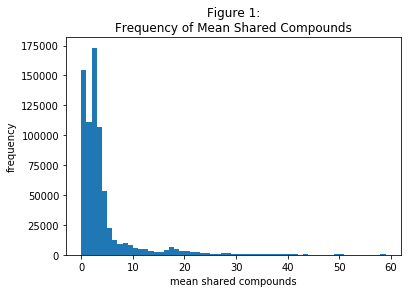

In [41]:
msc_data = food_msc.reshape(len_flavor**2)

print('Average: ' + str(np.average(msc_data)))
print('Median: ' + str(np.median(msc_data)))

fignum = 1
plt.hist(msc_data, bins=list(range(60)))
plt.title('Figure ' + str(fignum) + ':\nFrequency of Mean Shared Compounds')
plt.xlabel('mean shared compounds')
plt.ylabel('frequency')
plt.show()
fignum += 1

This shouldn't be that surprising; only similar foods (like beef and pork) should have similar compounds in them. The vast majority of foods taste really different from one another!

But wait - how similar are foods within each category? How similar are they to other categories? What are our categories?

In [47]:
set(flavor_df['category'])

{'additive',
 'bakery',
 'berry',
 'beverage',
 'beverage alcoholic',
 'beverage caffeinated',
 'cabbage',
 'cereal',
 'dairy',
 'dish',
 'essential oil',
 'fish',
 'flower',
 'fruit',
 'fruit citrus',
 'fruit essence',
 'fruit-berry',
 'fungus',
 'gourd',
 'herb',
 'legume',
 'maize',
 'meat',
 'nut',
 'plant',
 'plant derivative',
 'seafood',
 'seed',
 'spice',
 'vegetable',
 'vegetable fruit',
 'vegetable root',
 'vegetable stem',
 'vegetable tuber'}

Oops. It looks like we still have some more data cleaning to do. What's the difference between a vegetable, fruit, and vegetable fruit? How come cabbage gets its own category? Let's take a closer look. If we take a quick glance through the names of *every* food in FlavorDB (output not included), we'll notice a few strange things:

In [63]:
aliases_by_category = ''
for c in set(flavor_df['category']):
    aliases_by_category += (
        c + ': '
        + str(list(flavor_df[flavor_df['category'] == c]['alias']))
        + '\n\n'
    )
# print(aliases_by_category)

It looks like some entries/categories were made erroneously (see elderberry, cornbread, mixed nuts). A few looked incorrect but were correct (corn salad, or cornsalad, is a type of leafy vegetable), but a lot were seemed like they were sorted to make sure no one category is too large. However, I can see signficant differences in flavor between categories.

We're mostly interested in the ingredients list, not in finished products like cornbread, so we'll keep only raw ingredients, and remove a few outliers.

(Also: woah! [Apparently tobacco is a food.](https://www.scmp.com/magazines/post-magazine/article/1701428/how-cook-using-tobacco-sweet-and-savoury-dishes))